# AML Assignment-1

| Name                | ID         |
|---------------------|------------|
| Ananya Sinha        | MDS202307  |
| Divyanshi Kumari    | MDS202322  |
| Rohit Roy           | MDS202340  |

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Question 1

In [215]:
# Download and load the training and test sets
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)

# Checking if the dataset is loaded correctly
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# New category mapping: 0 = Clothes, 1 = Shoes, 2 = Others
def map_to_new_category(label):
    if label in [0, 1, 2, 3, 4, 6]:  # Clothes
        return 0
    elif label in [5, 7, 9]:         # Shoes
        return 1
    elif label == 8:                 # Others (Bag)
        return 2

# Example: Getting a batch of images and converting labels to the new categories
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Map the original labels to new categories
new_labels = torch.tensor([map_to_new_category(label) for label in labels])

# New category names
new_classes = ['Clothes', 'Shoes', 'Others']

# Print the new labels for the batch
print(f"Images batch shape: {images.shape}")
print(f"Original Labels batch shape: {labels.shape}")
print(f"New Labels: {new_labels}")
print(f"First new label: {new_classes[new_labels[0]]}")

# Modify the dataset loader to map the original labels to new categories
class CustomFashionMNIST(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        new_label = map_to_new_category(label)
        return image, torch.tensor(new_label)

trainset_custom = CustomFashionMNIST(trainset)
testset_custom = CustomFashionMNIST(testset)

trainloader_custom = torch.utils.data.DataLoader(trainset_custom, batch_size=64, shuffle=True)
testloader_custom = torch.utils.data.DataLoader(testset_custom, batch_size=64, shuffle=False)

Images batch shape: torch.Size([64, 1, 28, 28])
Original Labels batch shape: torch.Size([64])
New Labels: tensor([2, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 0, 1, 2, 0, 0, 0, 0, 1, 2, 1, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])
First new label: Others


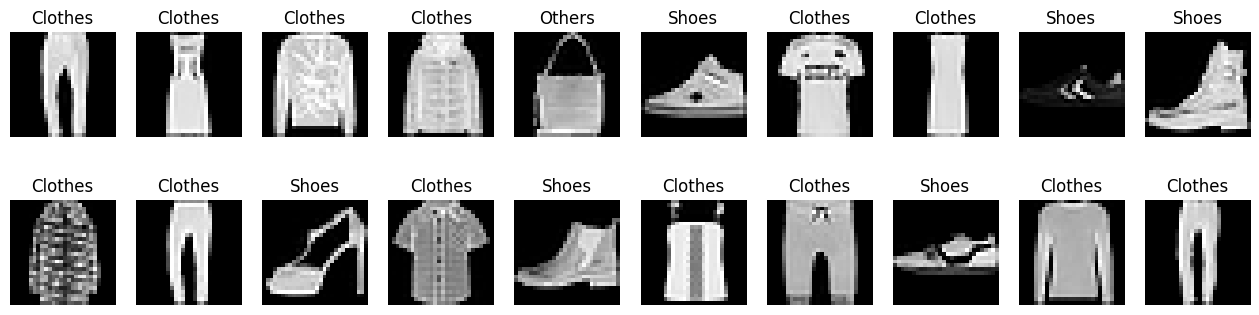

In [216]:
# show some training images
def imshow(img, plot):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()   # convert from tensor
    plot.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray') 
    
# show some training images
plt.figure(figsize=(16, 4))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(trainloader_custom))

for i in range(20):
    image = image_batch[i]
    label = label_batch[i].item()
    plt.subplot(2, 10, i + 1)
    imshow(image,plt)
    plt.axis('off')
    plt.title(new_classes[label])

In [217]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolutional Layer 1: Input channels = 1 (grayscale), Output channels = 16, Kernel size = 3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        # Convolutional Layer 2: Input channels = 16, Output channels = 32, Kernel size = 3
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Convolutional Layer 3: Input channels = 32, Output channels = 64, Kernel size = 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # MaxPooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layer with p=0.25
        self.do1 = nn.Dropout2d(p=0.25)
        
        # Fully Connected Layer 1: Input size is 64 * 3 * 3 after three pooling layers, output = 128
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        
        # Fully Connected Layer 2: 128 units to 64 units
        self.fc2 = nn.Linear(128, 64)
        
        # Fully Connected Layer 3 (Output Layer): 64 units to 3 units for 3 classes
        self.fc3 = nn.Linear(64, 3)
        
    def forward(self, x):
        # Convolutional Layer 1 with ReLU and MaxPooling
        x = self.pool(F.relu(self.conv1(x)))
        
        # Convolutional Layer 2 with ReLU and MaxPooling
        x = self.pool(F.relu(self.conv2(x)))
        
        # Convolutional Layer 3 with ReLU and MaxPooling
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output from the convolutional layers
        x = x.view(-1, 64 * 3 * 3)
        
        # Fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = self.do1(x)
        x = F.relu(self.fc2(x))
        
        # Output layer with softmax activation for classification
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x

# Instantiate the model
model = CNN()
model.to(device)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (do1): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)

In [218]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [219]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list = []
# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader_custom):
        # send to device
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader_custom.dataset),
                100. * batch_idx / len(trainloader_custom), loss.item()))
            
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader_custom:
        # send to device
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(testloader_custom.dataset)
    accuracy = 100. * correct / len(testloader_custom.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader_custom.dataset),
        accuracy))

In [220]:
print("Training on ", device)
# optimizer = optim.SGD(model.parameters(), lr=0.1)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 5):
    train(epoch, model)
    test(model)

Training on  cuda
Number of parameters: 105603
Train Epoch: 0 [0/60000 (0%)]	Loss: 1.152214


/home/rohitroy/miniconda3/envs/assigns/lib/python3.12/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.092986
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.016283
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.010654
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.049418
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.005819
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.081239
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.010321
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.007895
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.005045

Test set: Average loss: 0.0331, Accuracy: 9901/10000 (99%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.016276
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.006775
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.005108
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.003126
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.013171
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.009857
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.014814
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.015888
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.028856
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.034

In [221]:
def visualize_predictions(model, testloader, device='cpu', n_images=10):
    model.to(device)  # Ensure model is on the right device
    model.eval()  # Set the model to evaluation mode

    # Fetch a batch of test images
    image_batch, label_batch = next(iter(testloader))
    image_batch, label_batch = image_batch.to(device), label_batch.to(device)

    # Disable gradient computation for faster inference
    with torch.no_grad():
        log_pred_prob_batch = model(image_batch)  # Get the log probabilities from the model

    # Loop through the first 10 images and their predictions
    for i in range(n_images):
        img = image_batch[i].cpu()  # Move image back to CPU for plotting
        real_label = label_batch[i].item()
        log_pred_prob = log_pred_prob_batch[i]
        pred_prob = torch.exp(log_pred_prob).cpu().numpy().squeeze()  # Convert log probabilities to probabilities

        pred_label = np.argmax(pred_prob)

        # Visualize image, real and predicted labels, and prediction probabilities
        fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)

        # Handle RGB and Grayscale images (FashionMNIST is grayscale)
        ax1.imshow(img.squeeze(), cmap='gray')  # Grayscale image
        ax1.axis('off')
        ax1.set_title(f"pred: {new_classes[pred_label]}\nreal : {new_classes[real_label]}")
        
        ax2.barh(np.arange(len(new_classes)), pred_prob)
        ax2.set_aspect(0.1)
        ax2.set_yticks(np.arange(len(new_classes)))
        ax2.set_yticklabels(new_classes)
        ax2.set_title('Prediction Probability')
        ax2.set_xlim(0, 1.1)
        plt.tight_layout()
        plt.show()

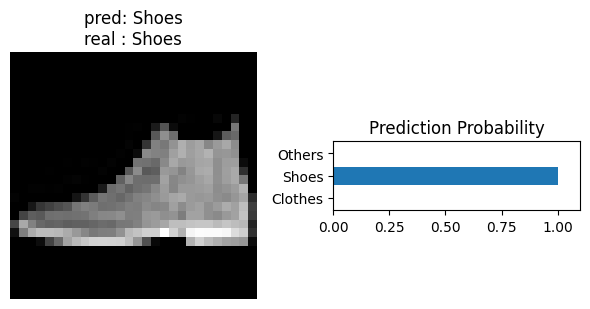

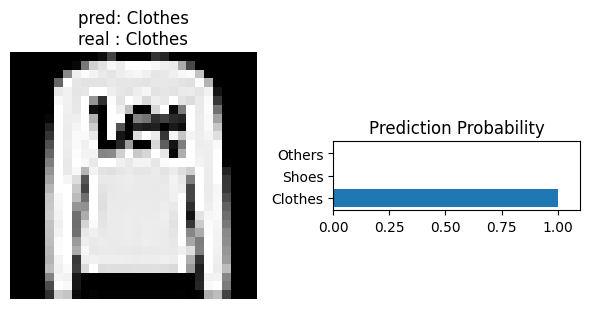

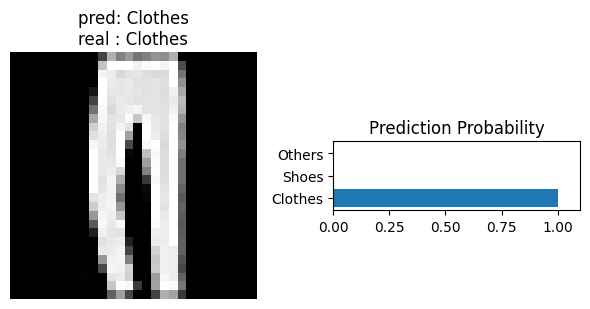

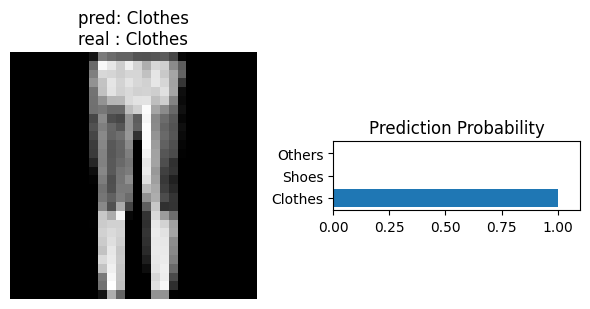

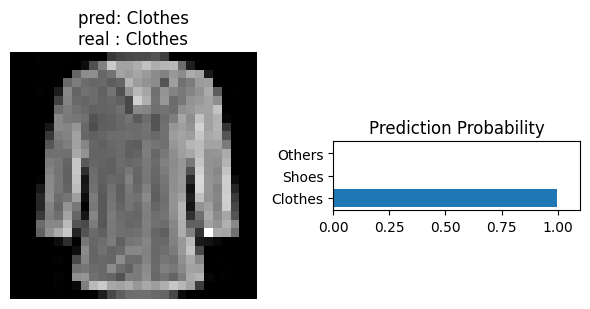

In [222]:
visualize_predictions(model, testloader_custom, device='cpu', n_images=5)

#### Scrambled Data Training

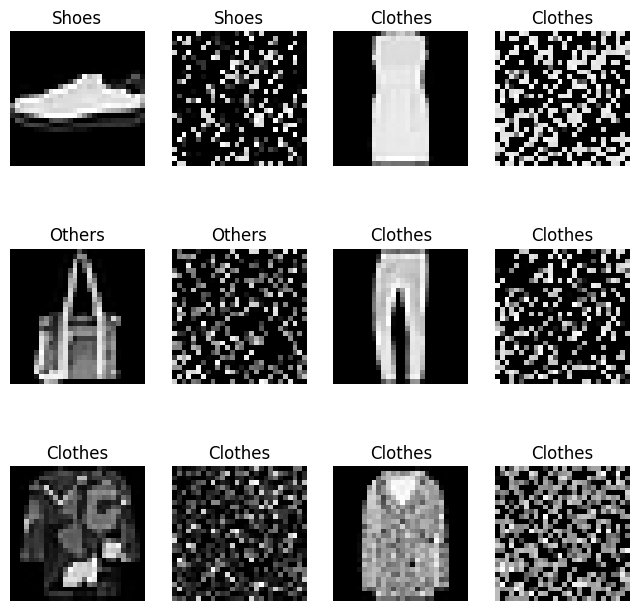

In [223]:
fixed_perm = torch.randperm(784) # Fix a permutation of the image pixels; We apply the same permutation to all images

# show some training images
plt.figure(figsize=(8, 8))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(trainloader_custom))

for i in range(6):
    image = image_batch[i]
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, fixed_perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    
    label = label_batch[i].item()
    plt.subplot(3,4 , 2*i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(new_classes[label])
    plt.subplot(3, 4, 2*i+2)
    plt.imshow(image_perm.squeeze().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(new_classes[label])

In [224]:
accuracy_list = []

def scramble_train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader_custom):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader_custom.dataset),
                100. * batch_idx / len(trainloader_custom), loss.item()))
            
def scramble_test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader_custom:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(testloader_custom.dataset)
    accuracy = 100. * correct / len(testloader_custom.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader_custom.dataset),
        accuracy))

In [225]:
print("Training on ", device)
model_scramble = CNN()
model_scramble.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_scramble.parameters(), lr=0.001)
print('Number of parameters: {}'.format(get_n_params(model_scramble)))

for epoch in range(0, 5):
    scramble_train(epoch, model_scramble, fixed_perm)
    scramble_test(model_scramble, fixed_perm)

Training on  cuda
Number of parameters: 105603
Train Epoch: 0 [0/60000 (0%)]	Loss: 1.032168


/home/rohitroy/miniconda3/envs/assigns/lib/python3.12/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.260846
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.062349
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.064538
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.029020
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.020503
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.037350
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.016659
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.013604
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.083154

Test set: Average loss: 0.0424, Accuracy: 9870/10000 (99%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.011540
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.019547
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.019097
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.034935
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.003059
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.065894
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.030932
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.008555
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.021409
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.086

In [226]:
def visualize_predictions_scramble(model, testloader, device='cpu', n_images=10):
    model.to(device)  # Ensure model is on the right device
    model.eval()  # Set the model to evaluation mode

    # Fetch a batch of test images
    image_batch, label_batch = next(iter(testloader))
    image_batch_scramble = image_batch.view(-1, 28*28)
    image_batch_scramble = image_batch_scramble[:, fixed_perm]
    image_batch_scramble = image_batch_scramble.view(-1, 1, 28, 28)
    image_batch, label_batch = image_batch.to(device), label_batch.to(device)
    permuted_image_batch = image_batch_scramble.to(device)

    # Disable gradient computation for faster inference
    with torch.no_grad():
        log_pred_prob_batch = model(permuted_image_batch)  # Get the log probabilities from the model

    # Loop through the first 10 images and their predictions
    for i in range(n_images):
        img_original = image_batch[i].cpu()  # Original image
        img_permuted = permuted_image_batch[i].cpu()  # Permuted image
        real_label = label_batch[i].item()
        log_pred_prob = log_pred_prob_batch[i]
        pred_prob = torch.exp(log_pred_prob).cpu().numpy().squeeze()  # Convert log probabilities to probabilities

        pred_label = np.argmax(pred_prob)

        # Visualize original image, permuted image, real and predicted labels, and prediction probabilities
        fig, (ax1, ax2, ax3) = plt.subplots(figsize=(9, 9), ncols=3)

        # Original image on the left
        ax1.imshow(img_original.squeeze(), cmap='gray')
        ax1.axis('off')
        ax1.set_title("Original Image")

        # Permuted image in the middle
        ax2.imshow(img_permuted.squeeze(), cmap='gray')
        ax2.axis('off')
        ax2.set_title(f"Permuted Image\npred: {new_classes[pred_label]}\nreal: {new_classes[real_label]}")

        # Prediction probabilities on the right
        ax3.barh(np.arange(len(new_classes)), pred_prob)
        ax3.set_aspect(0.1)
        ax3.set_yticks(np.arange(len(new_classes)))
        ax3.set_yticklabels(new_classes)
        ax3.set_title('Prediction Probability')
        ax3.set_xlim(0, 1.1)

        plt.tight_layout()
        plt.show()

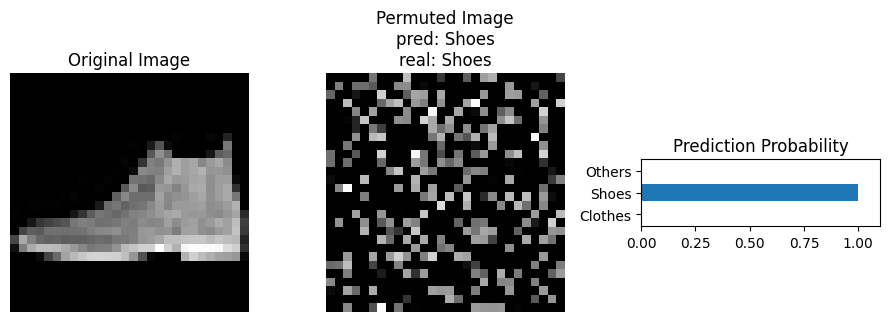

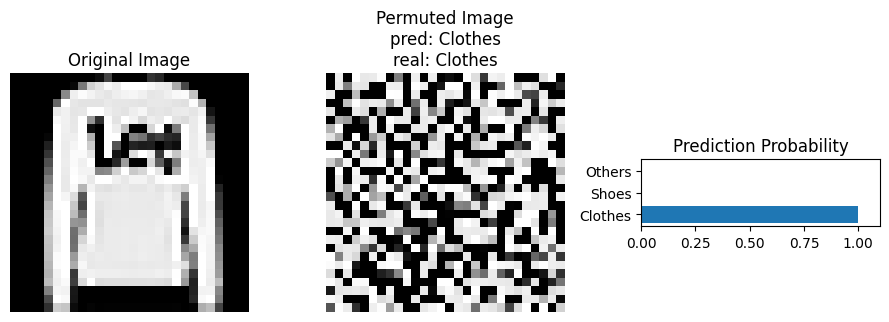

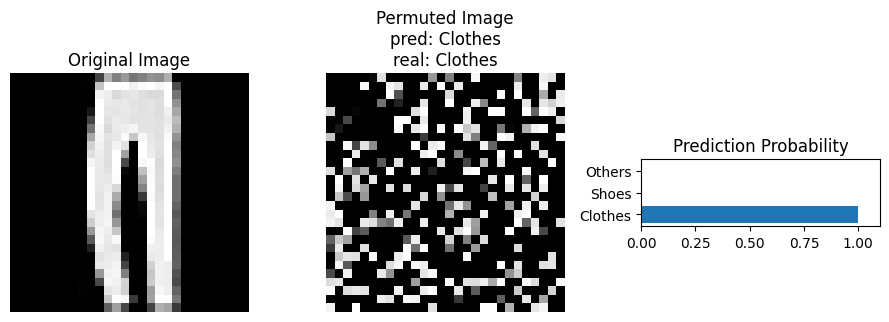

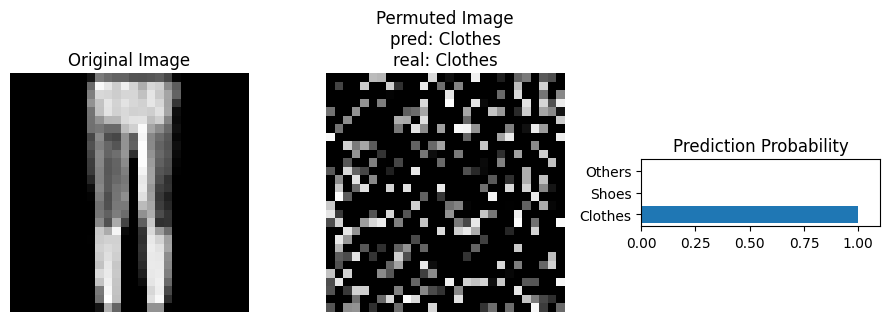

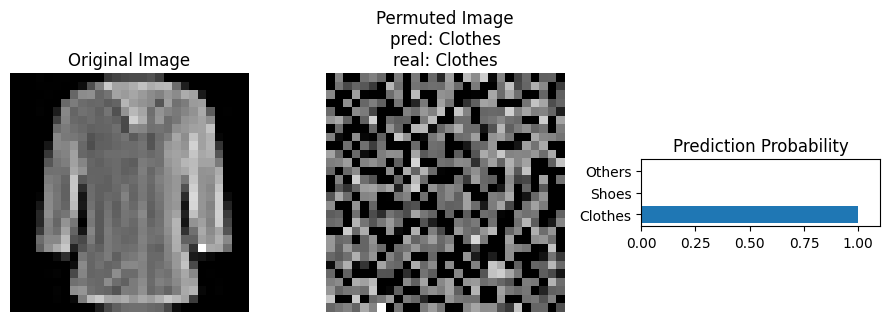

In [227]:
visualize_predictions_scramble(model_scramble, testloader_custom, device='cpu', n_images=5)

## Question 2

In [6]:
# Define transformations: Resize to 224x224, convert grayscale to RGB, and normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
full_train_data = ImageFolder(root='./data/EmotionData/train', transform=transform)
test_data = ImageFolder(root='./data/EmotionData/test', transform=transform)

# Create DataLoaders
train_loader = DataLoader(full_train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

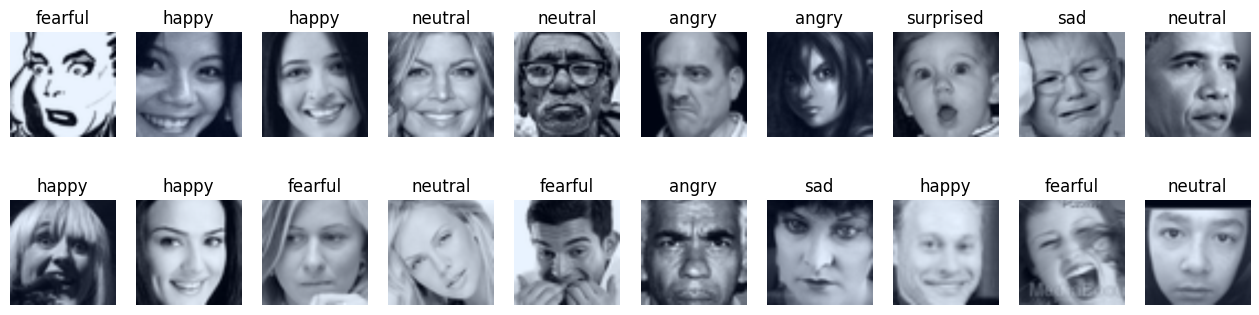

In [166]:
# show some training images
def imshow(img, plot):
    # Min-Max normalization for visualization purposes
    img = (img - img.min()) / (img.max() - img.min())
    npimg = img.numpy()   # convert from tensor
    plot.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray') 
    
# show some training images
plt.figure(figsize=(16, 4))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(20):
    image = image_batch[i]
    label = label_batch[i].item()
    plt.subplot(2, 10, i + 1)
    imshow(image,plt)
    plt.axis('off')
    plt.title(full_train_data.classes[label])

### ResNet-18 Implemented from Scratch

In [20]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet-18
resnet_scratch = models.resnet18(weights=None)  # No pre-trained weights
resnet_scratch.fc = nn.Linear(resnet_scratch.fc.in_features, len(full_train_data.classes))  
resnet_scratch = resnet_scratch.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_scratch.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop with validation and early stopping
def train_model(model, train_loader, criterion, optimizer, scheduler=None, epochs=10):
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        # Create a tqdm progress bar for the training loop
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()  # Zero the parameter gradients
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Calculate loss
                loss.backward()  # Backward pass
                optimizer.step()  # Optimize weights

                running_loss += loss.item()  # Update running loss
                pbar.set_postfix(loss=running_loss / (pbar.n + 1))  # Update progress bar
                pbar.update(1)  # Increment progress bar
            
        scheduler.step()  # Update learning rate
        
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}')

train_model(resnet_scratch, train_loader, criterion, optimizer,scheduler, epochs=10)

Epoch 1/10: 100%|██████████| 898/898 [01:20<00:00, 11.15batch/s, loss=1.75]


Epoch 1/10, Loss: 1.7519


Epoch 2/10: 100%|██████████| 898/898 [01:21<00:00, 11.08batch/s, loss=1.37]


Epoch 2/10, Loss: 1.3718


Epoch 3/10: 100%|██████████| 898/898 [01:21<00:00, 11.04batch/s, loss=1.18]


Epoch 3/10, Loss: 1.1822


Epoch 4/10: 100%|██████████| 898/898 [01:21<00:00, 11.05batch/s, loss=1.08]


Epoch 4/10, Loss: 1.0830


Epoch 5/10: 100%|██████████| 898/898 [01:21<00:00, 11.04batch/s, loss=0.996]


Epoch 5/10, Loss: 0.9957


Epoch 6/10: 100%|██████████| 898/898 [01:21<00:00, 11.05batch/s, loss=0.772]


Epoch 6/10, Loss: 0.7721


Epoch 7/10: 100%|██████████| 898/898 [01:21<00:00, 11.03batch/s, loss=0.679]


Epoch 7/10, Loss: 0.6792


Epoch 8/10: 100%|██████████| 898/898 [01:21<00:00, 11.06batch/s, loss=0.603]


Epoch 8/10, Loss: 0.6030


Epoch 9/10: 100%|██████████| 898/898 [01:19<00:00, 11.30batch/s, loss=0.522]


Epoch 9/10, Loss: 0.5218


Epoch 10/10: 100%|██████████| 898/898 [01:17<00:00, 11.63batch/s, loss=0.435]

Epoch 10/10, Loss: 0.4350


In [22]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

scratch_accuracy = evaluate_model(resnet_scratch, test_loader)

print(f"Accuracy of ResNet-18 trained from scratch: {scratch_accuracy*100:.2f}%")

Accuracy of ResNet-18 trained from scratch: 62.72%


### Fine-tuning on Pre-Trained ResNet-18

In [17]:
# Load pre-trained ResNet-18
resnet_pretrained_v2 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet_pretrained_v2.fc = nn.Linear(resnet_pretrained_v2.fc.in_features, len(full_train_data.classes))  # Adjust output layer
resnet_pretrained_v2 = resnet_pretrained_v2.to(device)

for param in resnet_pretrained_v2.parameters():
    param.requires_grad = False

for param in resnet_pretrained_v2.fc.parameters():
    param.requires_grad = True

for param in resnet_pretrained_v2.layer4.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

# Define optimizer to fine-tune the last convolutional block and fc layer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet_pretrained_v2.parameters()), lr=0.001)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Train the fine-tuned model
train_model(resnet_pretrained_v2, train_loader, criterion, optimizer, scheduler, epochs=10)

Epoch 1/10: 100%|██████████| 898/898 [00:54<00:00, 16.57batch/s, loss=1.19]


Epoch 1/10, Loss: 1.1930


Epoch 2/10: 100%|██████████| 898/898 [00:54<00:00, 16.61batch/s, loss=0.933]


Epoch 2/10, Loss: 0.9330


Epoch 3/10: 100%|██████████| 898/898 [00:53<00:00, 16.63batch/s, loss=0.712]


Epoch 3/10, Loss: 0.7117


Epoch 4/10: 100%|██████████| 898/898 [00:53<00:00, 16.85batch/s, loss=0.459]


Epoch 4/10, Loss: 0.4591


Epoch 5/10: 100%|██████████| 898/898 [00:53<00:00, 16.72batch/s, loss=0.264]


Epoch 5/10, Loss: 0.2635


Epoch 6/10: 100%|██████████| 898/898 [00:53<00:00, 16.71batch/s, loss=0.087] 


Epoch 6/10, Loss: 0.0870


Epoch 7/10: 100%|██████████| 898/898 [00:53<00:00, 16.67batch/s, loss=0.0363]


Epoch 7/10, Loss: 0.0363


Epoch 8/10: 100%|██████████| 898/898 [00:53<00:00, 16.71batch/s, loss=0.0221]


Epoch 8/10, Loss: 0.0221


Epoch 9/10: 100%|██████████| 898/898 [00:53<00:00, 16.80batch/s, loss=0.017] 


Epoch 9/10, Loss: 0.0170


Epoch 10/10: 100%|██████████| 898/898 [00:53<00:00, 16.72batch/s, loss=0.0145]

Epoch 10/10, Loss: 0.0145


In [18]:
pretrained_accuracy_v2 = evaluate_model(resnet_pretrained_v2, test_loader)

print(f"Accuracy of fine-tuned ResNet-18: {pretrained_accuracy_v2*100:.2f}%")

Accuracy of fine-tuned ResNet-18: 66.27%


#### Visualising the Difference between the two Models

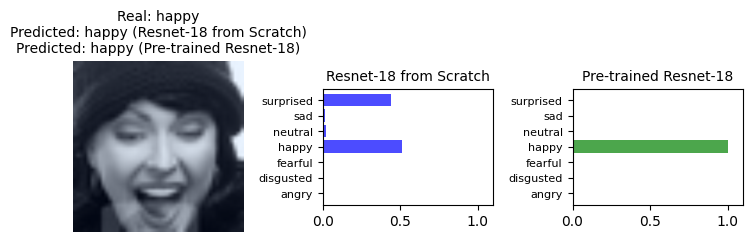

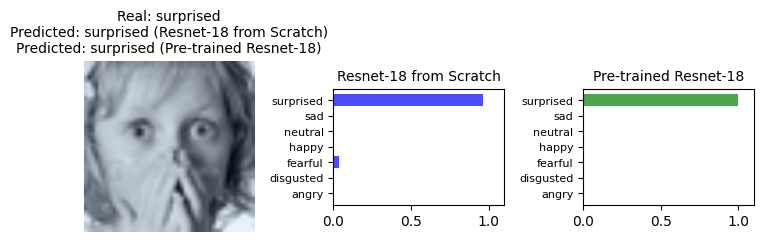

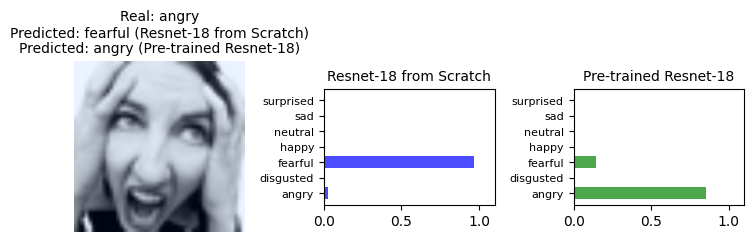

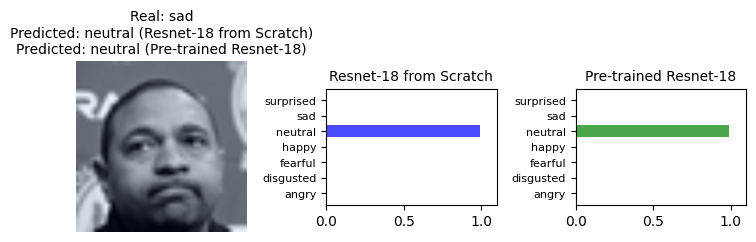

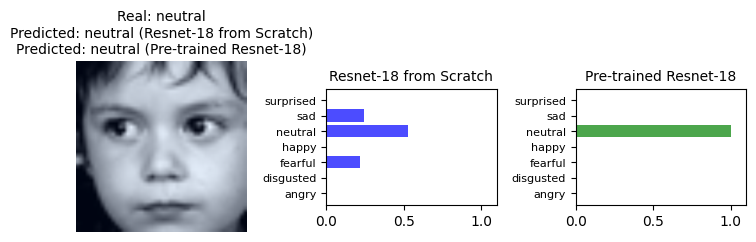

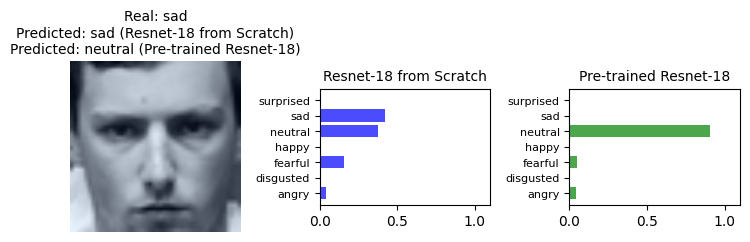

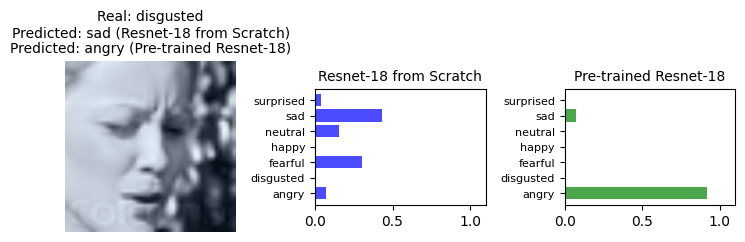

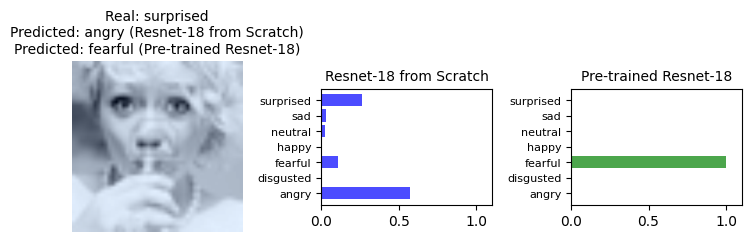

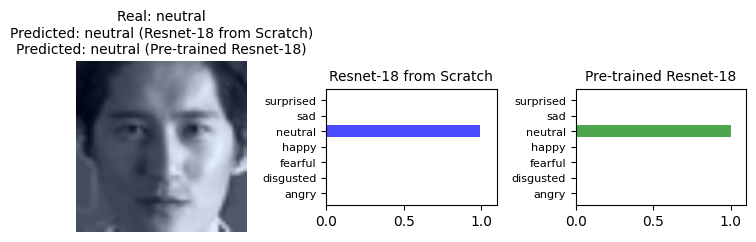

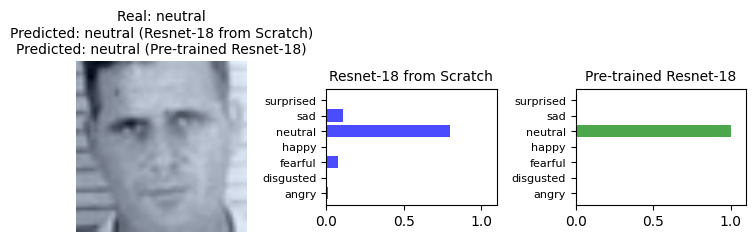

In [23]:
def visualize_predictions_dual(model1, model2, testloader, device='cpu', n_images=10):
    '''Visualising results of both: scratch and finetuned models'''
    model1.to(device)  # Ensure model1 is on the correct device
    model2.to(device)  # Ensure model2 is on the correct device
    model1.eval()  # Set model1 to evaluation mode
    model2.eval()  # Set model2 to evaluation mode

    # Initialize lists to collect images and labels
    images = []
    labels = []

    # Loop through the testloader to collect enough images
    for batch_images, batch_labels in testloader:
        images.append(batch_images)
        labels.append(batch_labels)
        
        # Break the loop when we have enough images
        if len(images) * batch_images.size(0) >= n_images:
            break

    # Concatenate collected images and labels
    image_batch = torch.cat(images, dim=0)[:n_images]
    label_batch = torch.cat(labels, dim=0)[:n_images]

    # Convert to three channels if the images are single-channel
    if image_batch.size(1) == 1:  # Check if the image has a single channel
        image_batch = image_batch.repeat(1, 3, 1, 1)  # Repeat the channel across three channels

    image_batch, label_batch = image_batch.to(device), label_batch.to(device)

    # Disable gradient computation for faster inference
    with torch.no_grad():
        # Get predictions from both models
        pred_prob_batch1 = model1(image_batch)  # Get the predicted logits from model1
        pred_prob_batch1 = torch.softmax(pred_prob_batch1, dim=1)  # Convert logits to probabilities
        
        pred_prob_batch2 = model2(image_batch)  # Get the predicted logits from model2
        pred_prob_batch2 = torch.softmax(pred_prob_batch2, dim=1)  # Convert logits to probabilities

    # Define class names (modify according to the dataset's labels)
    class_names = testloader.dataset.classes

    # Loop through the collected images and their predictions
    for i in range(min(n_images, len(image_batch))):
        img = image_batch[i].cpu().permute(1, 2, 0)  # Move image back to CPU and change shape for plotting

        # Min-Max normalization for visualization purposes
        img = (img - img.min()) / (img.max() - img.min())

        real_label = label_batch[i].item()
        pred_prob1 = pred_prob_batch1[i].cpu().numpy()
        pred_prob2 = pred_prob_batch2[i].cpu().numpy()

        pred_label1 = np.argmax(pred_prob1)
        pred_label2 = np.argmax(pred_prob2)

        # Visualize image, real and predicted labels, and prediction probabilities
        fig, axes = plt.subplots(figsize=(7, 4), ncols=3)  # Create three columns for image and probabilities

        # Display the normalized RGB image
        axes[0].imshow(img)
        axes[0].axis('off')
        axes[0].set_title(f"Real: {class_names[real_label]}\nPredicted: {class_names[pred_label1]} (Resnet-18 from Scratch)\nPredicted: {class_names[pred_label2]} (Pre-trained Resnet-18)", fontsize=10)

        # Display prediction probabilities as a bar chart for model 1
        axes[1].barh(np.arange(len(class_names)), pred_prob1, color='blue', alpha=0.7)
        axes[1].set_aspect(0.1)
        axes[1].set_yticks(np.arange(len(class_names)))
        axes[1].set_yticklabels(class_names, fontsize=8)
        axes[1].set_title('Resnet-18 from Scratch', fontsize=10)
        axes[1].set_xlim(0, 1.1)

        # Display prediction probabilities as a bar chart for model 2
        axes[2].barh(np.arange(len(class_names)), pred_prob2, color='green', alpha=0.7)
        axes[2].set_aspect(0.1)
        axes[2].set_yticks(np.arange(len(class_names)))
        axes[2].set_yticklabels(class_names, fontsize=8)
        axes[2].set_title('Pre-trained Resnet-18', fontsize=10)
        axes[2].set_xlim(0, 1.1)

        plt.tight_layout()
        plt.show()

vis_test = DataLoader(test_data, batch_size=100, shuffle=True)
visualize_predictions_dual(resnet_scratch, resnet_pretrained_v2, vis_test, device='cpu', n_images=10)